# Open-Science-prize quantum challenge 2021/22 by Quantum Polo Gang (Amico Valerio, Bensch Fabio,Pariente Ruben)

### Note


Our solution is for the *Qiskit default challenge*.


In chapter 3 we specify which solution we choose for the fidelity score.

# Abstract

We decide to split the XXX Hamiltonian into two pieces $H=H_1+H_2$ (instead of 6):
$$    H_1=I^{(0)} \otimes \sigma_x^{(1)} \otimes \sigma_x^{(2)}  + I^{(0)}  \otimes  \sigma_y^{(1)} \otimes \sigma_y^{(2)} + I^{(0)}  \otimes \sigma_z^{(0)} \otimes \sigma_z^{(1)}$$
$$ H_2=\sigma_x^{(0)}\otimes \sigma_x^{(1)} \otimes I^{(2)}  +  \sigma_y^{(0)} \otimes \sigma_y^{(1)} \otimes I^{(2)} + \sigma_z^{(0)} \otimes \sigma_z^{(1)} \otimes I^{(2)}$$

so using Trotter's formula (for a fixed number of steps $N$):
$$ e^{-iHt}=e^{-i(H_1 + H_2)t} \simeq \left(e^{-iH_1\frac{t}{N}}e^{-iH_2\frac{t}{N}}\right)^N \equiv (T_{step})^N \equiv T(t)$$

The main idea is to use Unitary Decomposition in a similar way as the one proposed in "https://arxiv.org/abs/2101.02993", instead of repeating a single $T_{step}$ N times that increase dramatically the depth of the circuit. In particular instead of using Quantum Shannon decomposition (QSD) we look for a Unitary Decomposition for which the gate $T_{step}^{N}$ has the same minimal depth for every time simulation and number of Trotter Steps.

In conclusion we are looking for a gate $U_{best}$ such that:
$$U_{best}(t) \ket{110} = T(t) \ket{110}$$

This can be intended in two ways:

* $U_{best} = T$ (equality between operators)
* $U_{best} \neq T$, but the two different operators applied to the same vector yield the same result

We followed both approaches, the former will be called *Hilbert Space Decomposition* (HSD) while for the latter we chose the name of *Single State Decomposition* (SSD).

For HSD the best circuit we found is composed of 11 CNOTs (14 for the Jakarta geometry) while for the SSD approach we reached an even better 4 CNOTs solution.

Furthermore, referring to qiskit's measurement error mitigation strategy (*https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html*), we tried to model also the noise introduced by the circuit instead of narrowing ourselves down to measurement error only.

# 1) Decompositions

We suggest two possible decomposition methods. Both are attempts to reconduce the trotterized evolution to two-qubit gates, since those are decomposed more efficiently. 

## 1.1) Single State Decomposition

We start from observing that the hamiltonian preserves the magnetization:
$$m = \sum_i \sigma_z^{(i)}\; ; \;\;\;  [H,m]=0$$
We want to implement  a 3-qubit magnetization-preserving gate using two 2-qubit gates in succession that preserve the magnetization too.
$$U_{best} = \left( \mathbb{I}^{(0)} \otimes M^{(1,2)} \right) \cdot \left( M^{(0,1)} \otimes \mathbb{I}^{(2)}  \right)  $$
We search thus the most general form of a 2-qubit magnetization-preserving gate.
Following https://arxiv.org/pdf/2106.13839.pdf, we want to generalize the Givens Rotation Gate to a SU(2) operator in the subspace $\ket{01},\ket{10}$:

$$ M(\omega,\theta, \phi) = \left[\begin{matrix}e^{ -i \left( \phi + \theta\right)} & 0 & 0 & 0\\ 0 & e^{-  i \left(\phi + \theta\right)} \cos{\left(\omega \right)} & - e^{-  i \left( \phi - \theta\right)} \sin{\left(\omega \right)} & 0\\ 0 & e^{ i \left( \phi - \theta\right)} \sin{\left(\omega \right)} & e^{ i \left( \phi + \theta\right)} \cos{\left(\omega \right)} & 0\\ 0 & 0 & 0 & e^{ i \left( \phi + \theta\right)}\end{matrix}\right] $$

The M gate can be decompose with just 2 c-nots.

Fixed the initial state to $\ket{110}$, we have that $M^{(1,2)}M^{(0,1)}\ket{110}$ spans the whole magnetization eigenspace. 
$$U_{best} = \left(  \mathbb{I} \otimes M(\omega_2,\theta_2, \phi_2)\right)     \cdot     \left( M(\omega_1,\theta_1, \phi_1) \otimes \mathbb{I} \right)   $$

So taking: $$T\ket{110} = \alpha \ket{011} + \beta \ket{101} + \gamma \ket{110}$$

where the $T(t)$ matrix is computed numerically and: 

$$\begin{align*}

U_{best}\ket{110} =\; &e^{i(\theta_1 - \phi_1 + \theta_2 - \phi_2)}\sin(\omega_1)\sin(\omega_2) \ket{011} +\\
& e^{i(\theta_1-\phi_1-\theta_2-\phi_2-\pi)}\sin(\omega_1)\cos(\omega_2) \ket{101} + \\
&e^{i(\theta_1+\phi_1+\theta_2+\phi_2)}\cos(\omega_2) \ket{110}

\end{align*}$$

Matching the amplitudes and solving the system for $\{\omega, \theta, \phi \}_{1,2}$ we get the parameters for the gates $M^{(0,1)}$ and $M^{(1,2)}$.


## Circuits: 


In [1]:
import numpy as np
# next we assume these values of TIME and N_STEPS for all the codes 
N_STEPS = 99
# since the calibration dosn't depend on time
# we can chose different time for evolution and calibration.
# we explain it in mitigation chapter.
TIME = np.pi
CALIBRATION_TIME = np.pi
# the initial state is fixed to 110

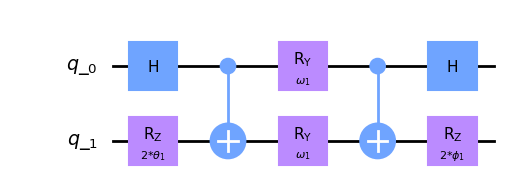

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

def get_M(theta, phi, omega, name="M"): # defining the M matrix

    qr=QuantumRegister(2, name="q_")
    M_qc=QuantumCircuit(qr, name=name)

    M_qc.rz(2*theta,qr[1])
    M_qc.h(qr[0])
    M_qc.cx(qr[0],qr[1])
    M_qc.ry(omega,qr)
    M_qc.cx(qr[0],qr[1])
    M_qc.h(qr[0])
    M_qc.rz(2*phi,qr[1])

    return M_qc

theta_1, phi_1, omega_1  = Parameter(r'$\theta_1$'), Parameter(r'$\phi_1$'), Parameter(r'$\omega_1$')
M1_qc = get_M(theta_1, phi_1, omega_1, name=r"$M_1$")

M1_qc.draw(output="mpl", style={"figwidth":6, "fontsize":11})

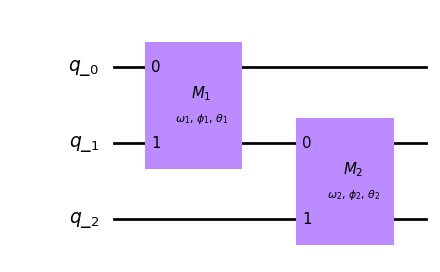

In [3]:
theta_2, phi_2, omega_2  = Parameter(r'$\theta_2$'), Parameter(r'$\phi_2$'), Parameter(r'$\omega_2$')
M2_qc = get_M(theta_2, phi_2, omega_2, name=r"$M_2$")

#building the circuit for the single state decomposition (SSD)
qr_U_best_SSD = QuantumRegister(3, name = "q_")
qc_U_best_SSD = QuantumCircuit(qr_U_best_SSD, name = r"$U_{best}$")

qc_U_best_SSD.append(M1_qc, [qr_U_best_SSD[0], qr_U_best_SSD[1]])
qc_U_best_SSD.append(M2_qc, [qr_U_best_SSD[1], qr_U_best_SSD[2]])

qc_U_best_SSD.draw(output = "mpl", style={"figwidth":5, "fontsize":11})

## 1.2) Hilbert Space Decomposition
This decomposition is based on the observation that the single trotter step can be reduced to  2 qubit gate by a permutation of the basis elements $B T_{step} B^{\dagger}=\mathbb{I}^{(2)} \otimes D^{(1,0)}_{step}$

so for the iteration:

$$B T_{step}^N B^{\dagger} = \mathbb{I} \otimes D =T_{B}(t)$$

where $D=D_{step}^{N}$ and $B$ is the matrix associated with the permutation $\left(\begin{matrix}0 & 1 & 2 & 3 & 4\\3 & 2 & 1 & 4 & 0 \end{matrix}\right)$, that in matrix form is

$$B = \left[
\begin{matrix}
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\end{matrix}
\right]$$

Therefore

$$ T_{B}(t) = B T(t) B^{\dagger}$$

So the final circuit is
$$T= B^{\dagger}\left(\mathbb{I} \otimes D\right) B$$


Since the initial state is just a permutation of the prepared state, we can prepare it already in the permutated one to avoid the noise introduced by a change of basis gate.
$$ \ket{\psi}_{prepared} = B\ket{\psi}_{init} $$

Then we use `qiskit.transpile()` function to decompose $D$ (up to 3 CNOTs), and we find the circuit for B using the permutation gates: x, CNOT and toffoli.

We also note that $B\ket{110} = \ket{110}$.

This decomposition works for a generic initial state of the Hilbert space. 


## Circuits:

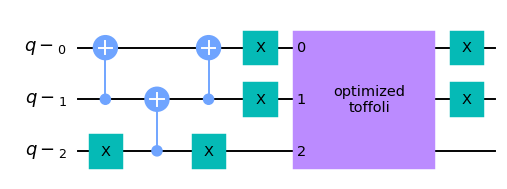

In [4]:
from lib import utilities
from lib.utilities import B
# built the permutation operator and the matrix associated to this circuit
B_qr=QuantumRegister(3, name="q-")
B_qc=QuantumCircuit(B_qr, name="B")
B_qc.x(B_qr[2])
B_qc.cx(B_qr[1],B_qr[0])
B_qc.cx(B_qr[2],B_qr[1])
B_qc.cx(B_qr[1],B_qr[0])
B_qc.x([B_qr[0],B_qr[1],B_qr[2]])
B_qc.append(utilities.Toffoli_gate,[B_qr[0],B_qr[1],B_qr[2]])
B_qc.x([B_qr[0],B_qr[1]])

B_qc.draw(output="mpl", style={"figwidth":6, "fontsize":15})

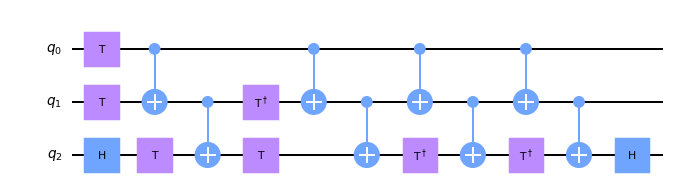

In [5]:
# where the toffoli gate is optimized for the Jakarta geometry.
utilities.Toffoli_gate.draw(output="mpl", style={"figwidth":8, "fontsize":11})

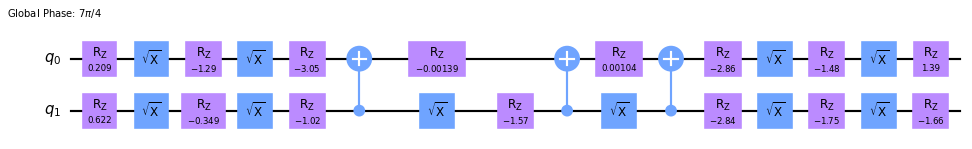

In [6]:
# The matrix D is a block of B' T B
# To avoid code redundancy, we defined the trotter operation 
# in the external script utilities.py

T = utilities.trotterized_matrix(TIME, N_STEPS)
T_b = np.linalg.multi_dot([ B, T, B.transpose() ])

D = T_b[0:4, 0:4]

from qiskit import transpile
# Transpile the D operator and build the evolution circuit
D_qc = QuantumCircuit(2, name="D")
D_qc.unitary(D,[0,1])    
D_qc = transpile(D_qc, basis_gates=['cx','x','sx','rz']) # Jackarta basis gates

D_qc.draw(output="mpl", style={"figwidth":13, "fontsize":11})

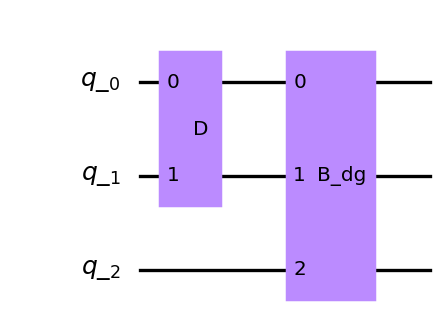

In [7]:
qr_U_best_HSD = QuantumRegister(3, name="q_")
qc_U_best_HSD = QuantumCircuit(qr_U_best_HSD, name="D")
# appending the D gate and the B.dagger permutation
qc_U_best_HSD.append(D_qc, [qr_U_best_HSD[0], qr_U_best_HSD[1]])
qc_U_best_HSD.append(B_qc.inverse(), qr_U_best_HSD)
# hilbert space decomposition evolution circuit
qc_U_best_HSD.draw(output="mpl", style={"figwidth":5, "fontsize":12})

## Comparison between SSD and HSD
* They both significantly reduce the complexity of the circuit, so we can simulate the Hisemberg XXX model with high fidelity scores.
* Since the SSD decompose the evolution within 4 c-not, while the HSD with 14 c-not (for Jakarta geometry), the fidelity score is higher for the SSD.
* SSD has no solution if we inizialize the system in an superposition of states with different magnetization, while the HSD can be used for a generic initial state.

Thus we choose the fidelity score of the *Single State Decomposition* as challenge solution.

# 2) Mitigation

The following haphazard processes affect the performance of the circuit:
* measurement noise (M)
* gate noise (N)
* state preparation noise 

we neglect the noise introduced by state mispreparation, so we assume the following model:

$$ C = MN \;\;\; ; \;\;\;\vec{p_{n}} = \|U_{noisy}\| \vec{p_{0}} = C \|U_{ideal}\| \vec{p_{0}}  = C \vec{p_{i}} $$

Where $\vec{p}_n$ and $\vec{p}_i$ are the probability vector noisy (which we measure) and ideal, C is a stochastic matrix that represents the noise of circuit and measure.
We use $ \|U\|$ to intend the probability matrix (or Unistochastic) of U $$\|U\|_{ij}=|U_{ij}|^{2}$$


So, characterizing the Calibration Matrix C we can mitigate the raw results. In particular, because of the shape of the circuit is the same for every evolution time, we can use the Calibration matrix computed for a particular time $t_{0}$ to mitigate the results of any time, and so build it once to mitigate multiple experiments. This is verified in the file "nome_file"
$$C(t_{0})\approx C(t)$$
For this particular case we computed $C(\pi)$

## 2.1) *Circuit Itself Calibration* (CIC)

We can caracterize the matrix $ \tilde{U} = C\|U\| $, just preparing all the $2^n$ computational basis states and evolve them with the circuit $U_{noisy}$ itself.
$$ \tilde{U}_{ij} =   (C\|U\|)_{ij} $$

So, the *calibration matrix* is:
$$ C = \tilde{U} \| U \|^{-1}  = C  \|U\| \|U\|^{-1}  $$

We note that if $||U||$ is not invertible must be excluded from this treatment  ($t=\pi$ is not the case). 
## Circuits:

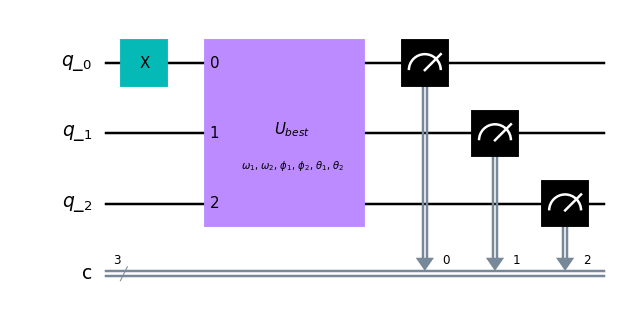

In [8]:
calib_circuits_CIC = []
# build a list of all computational basis states.
state_labels = ['000', '001', '010', '011', '100', '101', '110', '111']  
for state in state_labels:
    cr_cal_CIC = ClassicalRegister(3, name = "c")
    qr_cal_CIC = QuantumRegister(3, name = "q_")
    qc_cal_CIC = QuantumCircuit(qr_cal_CIC, cr_cal_CIC, name=f"mcalcal_{state}")
    # first we prepare the initial state.
    for qubit in [0,1,2]:
        if state[::-1][qubit] == "1":
            qc_cal_CIC.x(qr_cal_CIC[qubit])
    # then we append the circuit. Here is used U_best_SSD but you can use any operator.
    qc_cal_CIC.append(qc_U_best_SSD, qr_cal_CIC)
    qc_cal_CIC.measure(qr_cal_CIC, cr_cal_CIC)
    calib_circuits_CIC.append(qc_cal_CIC)
# example: for i = 1 we should preper the state |001> (gate x on first qubit).
calib_circuits_CIC[1].draw(output="mpl", style={"figwidth":7, "fontsize":12})


## 2.2) *Noisy Identity Calibration* (NIC)
In order to evaluate $C$ without the use of the ideal matrix (that could be a problem for more qubits), for all computational base states we use the following scheme:
* prepare the initial state in a fixed eigenvector of $U$: $U\ket{\lambda} = \lambda \ket{\lambda}$.
* apply U
* apply a state preparation operator $O_{i, \lambda}$ such that: $O_{i, \lambda} \ket{\lambda} = \ket{i}$, where $\ket{i}$ is the i-th state of the computational basis.

So, running the circuits:

$$ C_{i,j} = \bra{j}O_{i, \lambda}U_{noisy}\ket{\lambda} \simeq \bra{j} Id_{noisy} \ket{i} $$

For this specific case $\ket{000},\ket{111}$ are both eigenvector for SSD and only $\ket{111}$ for HSD.

If we assume that the gate noise doesn't depend on time, we can use the same calibration matrix (obtained with 8 circuits), to mitigate all the results of a temporal evolution (see pdf or .py script).

Note that NIC doesn't need to calculate numerically $||U||^{-1}$, so it's less computationally expensive compare to CIC method.
## Circuits:

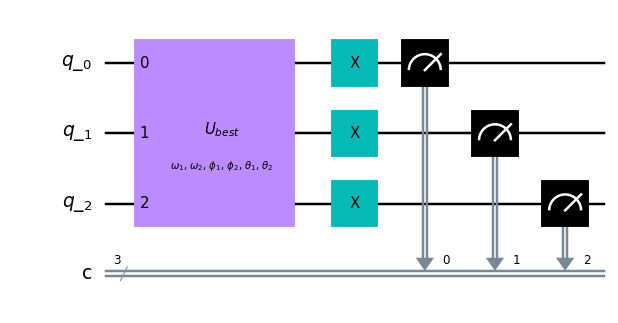

In [9]:
calib_circuits_NIC = []
# build the calibration circuits with NIC technique
for state in state_labels:
    cr_cal_NIC = ClassicalRegister(3, name = "c")
    qr_cal_NIC = QuantumRegister(3, name = "q_")
    qc_cal_NIC = QuantumCircuit(qr_cal_NIC, cr_cal_NIC, name=f"mcalcal_{state}")
    # The eigenvector of U_best is |000> so we prepare it.
    # first we append the circuit. Here is used U_best_SSD but you can use any operator.
    qc_cal_NIC.append(qc_U_best_SSD, qr_cal_NIC)
    # than we permute the state. 
    for qubit in range(3):
        if state[::-1][qubit] == "1":
            qc_cal_NIC.x(qr_cal_NIC[qubit])
    # measure all the qubits
    qc_cal_NIC.measure(qr_cal_NIC, cr_cal_NIC)
    calib_circuits_NIC.append(qc_cal_NIC)
# example: for i = 7 we should get the final state |111> (gate x on all qubits).
calib_circuits_NIC[7].draw(output="mpl", style={"figwidth":7, "fontsize":12})

## Comparison between CIC and NIC

* both are stable for any evoluition time.
* by testing them, we obteined on average slightly higher fidelity score with CIC.
* NIC doesn't require the numerical computation of the probability matrix of the circuit.

We choose for the fidelity score the CIC techniqe.

## *Fast Tomography Circuits Calibration*

Using NIC or CIC for each tomography base we should run $2^n$ circuit to calibrate it, so the total number of run would be $2^n \cdot 3^n$ calibration circuits, that is computationally high-expensive.

The *Fast Tomography Circuits Calibration* needs only $2^n$ calibration circuits.

The idea is to compute just once the calibration matrix in the computational basis and for every tomography basis compute $$C_{H}=\|H\|C\|H^{\dagger}\|$$ where H is the new basis matrix.

Clearly, if the calibration matrix does not dipend on time in the computational basis, also $C_H$ has this properties.

If for example we want to see the evolution at 50 differents values of time, with this procedure we don't need to measure the calibration matrix for all the times and then calculate the changes of bases, but we just need to do it for fixed time and then use the same calibration matrices for all the points.

So, instead of $50*3^n$ operations we need only $3^n$ (number of tomgraphy basis)

## Mitigation with Ancillas
Since parity and total magnetization are conserved during time evolution, we tried to measure with ancillas those quantities and reject all measurements that does not respect those constrains.

The circuits that we had to append to use ancillas were equally or even more deep than the time evolution circuit itself so we had no improvement, in terms of fidelity, in using them.  

# 3) Results

In the following both the NIC and CIC method are runned, using the single state decomposition. 

For the purposes of the challenge we choose the fidelity score obtained with the CIC technique and with the SSD decomposition.

## 3.1) *Single State Decomposition* results

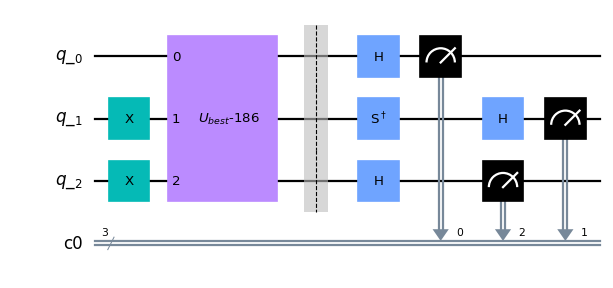

In [10]:
###################################################################
######################## Evolution tomography circuits preparation
# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.
trotterized = utilities.trotterized_matrix(TIME, N_STEPS)
# getting the parameters for the gates M1 and M2 for the SSD, solving the equations described in 1.1).
theta_1_, theta_2_, phi_1_, phi_2_, omega_1_, omega_2_ = utilities.get_gates_parameters(trotterized, 
                                                                                        initial_state={"110": 1.0})
# substituting the parameters with the just computed
qc_U_best_SSD = qc_U_best_SSD.bind_parameters({
    theta_1: theta_1_,
    theta_2: theta_2_,
    phi_1: phi_1_,
    phi_2: phi_2_,
    omega_1: omega_1_,
    omega_2: omega_2_
})

# building the tomography circuits
qr_SSD = QuantumRegister(3, name="q_")
qc_SSD = QuantumCircuit(qr_SSD, name=r"$U_{best}$")
# prepare the initial state |110>
qc_SSD.x([qr_SSD[1],qr_SSD[2]])
qc_SSD.append(qc_U_best_SSD, qr_SSD)
from qiskit.ignis.verification.tomography import state_tomography_circuits
# make the tomography circuits
qcs_tomo_SSD = state_tomography_circuits(qc_SSD, qr_SSD)
qcs_tomo_SSD[3].draw(output="mpl", style={"figwidth":7, "fontsize":12})

In [11]:
##################################################################
########## building the calibration circuits for both NIC and CIC
calibration_circuit_SSD, _ = utilities.get_evolution_circuit(CALIBRATION_TIME, N_STEPS, method="SSD")
calib_circuits_SSD_NIC = utilities.get_calibration_circuits(calibration_circuit_SSD, method="NIC", eigenvector="000")
calib_circuits_SSD_CIC = utilities.get_calibration_circuits(calibration_circuit_SSD, method="CIC")

from qiskit import IBMQ, execute
from qiskit.providers.aer import QasmSimulator

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')

#################################################################
########################################### execute all the jobs
BACKEND = backend_sim_noisy_jakarta
shots = 20000

job_SSD_NIC=execute(calib_circuits_SSD_NIC, backend = BACKEND, shots=shots, initial_layout=[1,3,5])
job_SSD_CIC=execute(calib_circuits_SSD_CIC, backend = BACKEND, shots=shots, initial_layout=[1,3,5])
job_tomography_SSD=execute(qcs_tomo_SSD, backend = BACKEND, shots=shots, initial_layout=[1,3,5])

In [12]:
#################################################################
#################################### Mititgation of the raw results
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
import copy
# building the matrices
meas_fitter_SSD_NIC = CompleteMeasFitter(job_SSD_NIC.result(), state_labels=state_labels)
meas_fitter_SSD_CIC = CompleteMeasFitter(job_SSD_CIC.result(), state_labels=state_labels)
# copy the measured probability matrices.
U_tilde_SSD_NIC = meas_fitter_SSD_NIC.cal_matrix
U_tilde_SSD_CIC = meas_fitter_SSD_CIC.cal_matrix
# U_ideal is the unitary matrix of the circuit qc_U, we will use it for the CIC method.
U_ideal_SSD = utilities.matrix_from_circuit(calibration_circuit_SSD)
# defining the tomography basis circuits.
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)
tomography_basis = state_tomography_circuits(qc_basi, qr_basi)

# compute the probability matrix of U_ideal and the inverse of it.
U_ideal_SSD_abs = np.abs(U_ideal_SSD)**2
U_ideal_SSD_abs_inv = np.linalg.inv(U_ideal_SSD_abs)
# built the calibration matrix in the computational basis for both CIC and NIC methods.
C_SSD_CIC = np.dot(U_tilde_SSD_CIC, U_ideal_SSD_abs_inv)
C_SSD_NIC = U_tilde_SSD_NIC
# building the fast tomography circuits calibration.
# next are computed the calibration matrices in all the tomography basis,
# and after are applyed to the raw result for both CIC and NIC.
raw_result_SSD = job_tomography_SSD.result()
NIC_result_SSD = copy.deepcopy(raw_result_SSD)
CIC_result_SSD = copy.deepcopy(raw_result_SSD)
for i, basis in enumerate(tomography_basis):
    basis.remove_final_measurements()
    # building the unitary matrix of the basis and the inverse.
    base_matrix_amplitudes = utilities.matrix_from_circuit(basis)
    base_matrix_amplitudes_inverse = np.linalg.inv(base_matrix_amplitudes)
    # building the probability matrices.
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2
    # change the basis of the calibration matrices for NIC and CIC.
    C_basis_CIC = np.linalg.multi_dot([base_matrix, C_SSD_CIC,  base_matrix_inverse])
    C_basis_NIC = np.linalg.multi_dot([base_matrix, C_SSD_NIC,  base_matrix_inverse])
    # changing the meas_fitter_SSD_NIC calibration matrix with the new calibration matrix. 
    meas_fitter_NIC_aus = copy.deepcopy(meas_fitter_SSD_NIC)
    meas_fitter_NIC_aus._tens_fitt.cal_matrices[0]=C_basis_NIC
    # changing the meas_fitter_SSD_CIC calibration matrix with the new calibration matrix. 
    meas_fitter_CIC_aus = copy.deepcopy(meas_fitter_SSD_CIC)
    meas_fitter_CIC_aus._tens_fitt.cal_matrices[0]=C_basis_CIC
    # computing the new counts for both the mitigation techniques
    old_counts=raw_result_SSD.get_counts(basis)
    new_counts_NIC = meas_fitter_NIC_aus.filter.apply(old_counts, method="least_squares")
    new_counts_CIC = meas_fitter_CIC_aus.filter.apply(old_counts, method="least_squares")
    NIC_result_SSD.results[i].data.counts = new_counts_NIC
    CIC_result_SSD.results[i].data.counts = new_counts_CIC


In [13]:
# defining a function for to compute the fidelity
from qiskit.ignis.verification.tomography import StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.opflow import One, Zero

def fidelity_count(result, qcs, target_state):
    '''
    returns the fidelity, given the job result, the tomography cicuits, and the targhet state.
    '''
    tomo_ising = StateTomographyFitter(result, qcs)
    rho_fit_ising = tomo_ising.fit(method="lstsq")
    fid=state_fidelity(rho_fit_ising, target_state)
    return fid


In [14]:
target_state = (One^One^Zero).to_matrix()  # (|q_5,q_3,q_1> = |110>)
# compute the fidelity
fid_raw = fidelity_count(raw_result_SSD, qcs_tomo_SSD, target_state)
fid_NIC = fidelity_count(NIC_result_SSD, qcs_tomo_SSD, target_state)
fid_CIC = fidelity_count(CIC_result_SSD, qcs_tomo_SSD, target_state)
# print the result
print(f"decomposition method: Single State Decomposition\nevolution time = {TIME/np.pi:.3} pi\nNumber of trotter steps = {N_STEPS}\n")
print(f"fidelity of raw results: {fid_raw} \nfidelity with NIC method: {fid_NIC}\nfidelity with CIC method: {fid_CIC}   this is the fidelity score for the challenge.")

decomposition method: Single State Decomposition
evolution time = 1.0 pi
Number of trotter steps = 99

fidelity of raw results: 0.8531055246917641 
fidelity with NIC method: 0.9931937736769968
fidelity with CIC method: 0.9994693914246496   this is the fidelity score for the challenge.


## 3.2) *Hilbert Space Decomposition* results

In [15]:
######################################################################
## build the calibration circuits for the Hilbert Space Decomposition
calibration_circuit_HSD, _ = utilities.get_evolution_circuit(CALIBRATION_TIME, N_STEPS, method="HSD")
calib_circuits_HSD_NIC = utilities.get_calibration_circuits(calibration_circuit_HSD, method="NIC", eigenvector="111")
calib_circuits_HSD_CIC = utilities.get_calibration_circuits(calibration_circuit_HSD, method="CIC")
# build the tomography circuits for the hilbert space decomposition.
qr_HSD = QuantumRegister(3, name="q_")
qc_HSD = QuantumCircuit(qr_HSD, name="HSD")
# preparing the initial state.
qc_HSD.x([qr_HSD[1], qr_HSD[2]])
qc_HSD.append(qc_U_best_HSD, qr_HSD)
# built the tomograpfhy circuits.
qcs_tomo_HSD = state_tomography_circuits(qc_HSD, qr_HSD)

######################################################################
###################################################### execute all
shots = 32000
job_tomo_HSD=execute(qcs_tomo_HSD, BACKEND, shots=shots, initial_layout=[1,3,5])
job_HSD_NIC=execute(calib_circuits_HSD_NIC, backend = BACKEND, shots=shots, initial_layout=[1,3,5])
job_HSD_CIC=execute(calib_circuits_HSD_CIC, backend = BACKEND, shots=shots, initial_layout=[1,3,5])

########################################################################
####################################################### Mitigation
# compute the U_ideal unitary matrix of the circuit.
U_ideal_HSD = utilities.matrix_from_circuit(calibration_circuit_HSD)
# fast_tomography_calibration_MeasFitters returns a list of 27 CompleteMeasFitter objects, one for each tomo basis.
meas_fitters_HSD_NIC = utilities.fast_tomography_calibration_MeasFitters(job_HSD_NIC.result(), method="NIC")
meas_fitters_HSD_CIC = utilities.fast_tomography_calibration_MeasFitters(job_HSD_CIC.result(), method="CIC", U_ideal=U_ideal_HSD)
# defining the target_state = |110> ; qubits: |5,3,1>
target_state = (One^One^Zero).to_matrix()
# compute the mitigated results.
raw_result_HSD = job_tomo_HSD.result()
NIC_result_HSD = copy.deepcopy(raw_result_HSD)
CIC_result_HSD = copy.deepcopy(raw_result_HSD)
for i in range(27):
    new_counts_NIC_HSD = meas_fitters_HSD_NIC[i].filter.apply(raw_result_HSD.get_counts(i), method="least_squares")
    new_counts_CIC_HSD = meas_fitters_HSD_CIC[i].filter.apply(raw_result_HSD.get_counts(i), method="least_squares")
    NIC_result_HSD.results[i].data.counts = new_counts_NIC_HSD
    CIC_result_HSD.results[i].data.counts = new_counts_CIC_HSD

In [16]:
fid_raw_HSD = utilities.fidelity_count(raw_result_HSD, qcs_tomo_HSD, target_state)
fid_NIC_HSD = utilities.fidelity_count(NIC_result_HSD, qcs_tomo_HSD, target_state)
fid_CIC_HSD = utilities.fidelity_count(CIC_result_HSD, qcs_tomo_HSD, target_state)

print("decomposition method: Hilbert Space Decomposition\nevolution time = %.3f pi\nnumber of trotter steps = %d\n"%(TIME/np.pi, N_STEPS))
print(f"fidelity of raw results: {fid_raw_HSD} \nfidelity with NIC method: {fid_NIC_HSD}\nfidelity with CIC method: {fid_CIC_HSD}")

decomposition method: Hilbert Space Decomposition
evolution time = 1.000 pi
number of trotter steps = 99

fidelity of raw results: 0.8180684190788184 
fidelity with NIC method: 0.971579471453297
fidelity with CIC method: 0.9996765474674578


# Conclusions

We would like to briefly highlight the advantages of our approach to the problem:
- Decompositions and ancillas
    - ancillas have not been used (savings in terms of number of bits), reducing length of circuits.
    - HSD works for every input state of the computational basis.
    - both HSD and SSD work for every time (not only $\pi$).
    - our algorithm keeps the fidelity error within the third digit. 
    
- Calibrations
    - both NIC and CIC are time independent
    - NIC only needs a $U$ eigenstate, not $U$ entirely
    - the noise can be inferred in every basis once it is computed in one